In [1]:
# Core analysis packages
import numpy as np
import os, sys
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import anova
from patsy import dmatrices
import bff
import pingouin as pg

# Plotting packages
import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns 
sns.set(style="ticks", color_codes=True)
sns.set_style("white")
sns.set_style({'xtick.bottom': True, 'ytick.left': True})
colorref = ["gray", "royalblue", "crimson", "goldenrod", "mediumorchid", "seagreen"]


# iPython magic commands
%matplotlib notebook
%load_ext autoreload
%autoreload 2
%autosave 120

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIG_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)  # fontsize of the figure title
cust_palette = sns.color_palette("Paired")[6:10]
cust_palette = [cust_palette[i] for i in [1,0,3,2]]

def median_split(S):
    return S > S.median()

/opt/anaconda3/envs/research/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.3.9.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


Autosaving every 120 seconds


In [2]:
def ttest_ind(x1, x2, equivar=False, alpha=0.05, printres=False):
    n1 = len(x1)
    M1 = np.mean(x1)
    s1 = np.std(x1, ddof=1)
    n2 = len(x2)
    M2 = np.mean(x2)
    s2 = np.std(x2, ddof=1)
    
    # t-test
    [t, p] = stats.ttest_ind(x1, x2, equal_var=equivar)
    # cohen's d
    dof = n1 + n2 - 2
    sp = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / dof)
    d = np.abs(M1 - M2) / sp
    # degrees of freedom
    df = (s1**2/n1 + s2**2/n2)**2 / ((s1**2/n1)**2/(n1-1) + (s2**2/n2)**2/(n2-1))
    # confidence intervals (M1 - M2) ± ts(M1 - M2)
    se = np.sqrt(sp**2/n1 + sp**2/n2)
    CI = (M1 - M2) + np.array([-1,1])*stats.t.ppf(1-alpha/2, df, loc=0, scale=1)*se

    res = (t, df, p, d, CI[0], CI[1])
    if printres:
        print("t = %.5f, df = %.5f, p = %.5f, d = %.5f, CI = (%.5f, %.5f)" % res)
    else:
        return res

In [3]:
# Load file (from same directory as the notebook)
df = pd.read_excel(os.path.expanduser("belief2behavPoliticalreplicationMTurk.xlsx"), index_col=0)
df.head()

,Unnamed: 1,BeliefPRE1,BeliefPRE2,BeliefPRE3,BeliefPRE4,BeliefPRE5,BeliefPRE6,BeliefPRE7,BeliefPRE8,BehavPRE1,...,ChoicePOSTi,ChoicePOSTd,Bchangei,Bchanged,Cchangei,Cchanged,BeliefPREi,BeliefPREd,ChoicePREi,ChoicePREd
Response ID,,,,,,,,,,,,,,,,,,,,,
R_1re3AQ8CMYkF47P,NaN,40,91,86,100,9,51,4,82,10,...,20.0,5.0,27.00,-58.00,7.5,-7.5,47.75,68.00,12.5,12.5
R_3suF0nAzuReK8pA,NaN,71,86,82,75,92,83,97,41,10,...,12.5,10.0,1.75,10.75,2.5,-2.5,83.00,73.75,10.0,12.5
R_1rD5IT1FeMs4jjR,NaN,59,60,55,59,65,61,63,60,10,...,10.0,12.5,-2.50,-3.00,0.0,0.0,61.25,59.25,10.0,12.5
R_2sd1nTCMARJS5Sw,NaN,91,84,85,91,90,89,88,90,10,...,10.0,10.0,2.50,0.25,0.0,-2.5,88.50,88.50,10.0,12.5
R_phDbhhnD3WJUr3X,NaN,4,40,79,100,28,25,0,99,100,...,0.0,12.5,40.50,-18.00,-25.0,12.5,24.25,69.50,25.0,0.0


In [4]:
# Extract columns with df.target or df["target"] or df.loc[:,"target"]
age = df.loc[:, "Age"]
ide = df.loc[:,"Ide"]

BeliefPOSTi = df.loc[:,"BeliefPOSTi"]
BeliefPOSTd = df.loc[:,"BeliefPOSTd"]
ChoicePOSTi = df.loc[:,"ChoicePOSTi"]
ChoicePOSTd = df.loc[:,"ChoicePOSTd"]
Bchangei = df.loc[:,"Bchangei"]
Bchanged = df.loc[:,"Bchanged"]
Cchangei = df.loc[:,"Cchangei"]
Cchanged = df.loc[:,"Cchanged"]

partnum = np.arange(ide.size)

In [5]:
# Extract data with df.loc[:,"datastart":"dataend"]
BeliefPRE = df.loc[:, "BeliefPRE1":"BeliefPRE8"]
BeliefPOST = df.loc[:, "BeliefPOST1":"BeliefPOST8"]
ChoicePRE = df.loc[:, "BehavPRE1":"BehavPRE8"]
ChoicePOST = df.loc[:, "BehavPOST1":"BehavPOST8"]
RdeltaB = df.loc[:, "RB1":"RB8"]
RdeltaC = df.loc[:, "RC1":"RC8"]
deltaB = df.loc[:, "Bchange1":"Bchange8"]
deltaC = df.loc[:, "Cchange1":"Cchange8"]

sz = RdeltaB.shape
itemnum = np.arange(sz[-1])
print(sz)

(393, 8)


In [6]:
# Data and row-wise labels first
names = ["BeliefPRE", "BeliefPOST", "ChoicePRE", "ChoicePOST", 'RdeltaB', 'RdeltaC', 'deltaB','deltaC','itemnum', \
         "age", "ide", 'BeliefPOSTi', 'BeliefPOSTd','ChoicePOSTi','ChoicePOSTd','Bchangei','Bchanged','Cchangei','Cchanged',"partnum"]
data_packed = np.broadcast_arrays(BeliefPRE, BeliefPOST, ChoicePRE, ChoicePOST, RdeltaB, RdeltaC, deltaB, deltaC, itemnum)
# Then column-wise labels
cols = [np.tile(a, (sz[1],1)).T for a in [age, ide, BeliefPOSTi, BeliefPOSTd,ChoicePOSTi,ChoicePOSTd,Bchangei,Bchanged,Cchangei,Cchanged, partnum]]
data_packed += cols

data_unpacked = np.vstack([np.reshape(a, (1,-1), order="C") for a in data_packed]).T
DATA = pd.DataFrame(data=data_unpacked, columns=names)

DATA.head()

,BeliefPRE,BeliefPOST,ChoicePRE,ChoicePOST,RdeltaB,RdeltaC,deltaB,deltaC,itemnum,age,ide,BeliefPOSTi,BeliefPOSTd,ChoicePOSTi,ChoicePOSTd,Bchangei,Bchanged,Cchangei,Cchanged,partnum
0,40.0,100.0,10.0,0.0,60.0,-10.0,60.0,-10.0,0.0,43.0,1.0,74.75,10.0,20.0,5.0,27.0,-58.0,7.5,-7.5,0.0
1,91.0,100.0,40.0,80.0,9.0,40.0,9.0,40.0,1.0,43.0,1.0,74.75,10.0,20.0,5.0,27.0,-58.0,7.5,-7.5,0.0
2,86.0,2.0,30.0,20.0,84.0,10.0,-84.0,-10.0,2.0,43.0,1.0,74.75,10.0,20.0,5.0,27.0,-58.0,7.5,-7.5,0.0
3,100.0,20.0,20.0,0.0,80.0,20.0,-80.0,-20.0,3.0,43.0,1.0,74.75,10.0,20.0,5.0,27.0,-58.0,7.5,-7.5,0.0
4,9.0,90.0,0.0,0.0,81.0,0.0,81.0,0.0,4.0,43.0,1.0,74.75,10.0,20.0,5.0,27.0,-58.0,7.5,-7.5,0.0


In [7]:
# Group and average data within participant
AVDATA = DATA.groupby(["partnum"], as_index=False).mean()
AVDATA.head()

,partnum,BeliefPRE,BeliefPOST,ChoicePRE,ChoicePOST,RdeltaB,RdeltaC,deltaB,deltaC,itemnum,age,ide,BeliefPOSTi,BeliefPOSTd,ChoicePOSTi,ChoicePOSTd,Bchangei,Bchanged,Cchangei,Cchanged
0,0.0,57.875,42.375,12.50,12.50,42.500,7.50,-15.500,0.00,3.5,43.0,1.0,74.75,10.00,20.0,5.0,27.00,-58.00,7.5,-7.5
1,1.0,78.375,84.625,11.25,11.25,-4.500,2.50,6.250,0.00,3.5,54.0,1.0,84.75,84.50,12.5,10.0,1.75,10.75,2.5,-2.5
2,2.0,60.250,57.500,11.25,11.25,0.250,0.00,-2.750,0.00,3.5,46.0,1.0,58.75,56.25,10.0,12.5,-2.50,-3.00,0.0,0.0
3,3.0,88.500,89.875,11.25,10.00,1.125,1.25,1.375,-1.25,3.5,35.0,1.0,91.00,88.75,10.0,10.0,2.50,0.25,0.0,-2.5
4,4.0,46.875,58.125,12.50,6.25,29.250,-18.75,11.250,-6.25,3.5,32.0,1.0,64.75,51.50,0.0,12.5,40.50,-18.00,-25.0,12.5


<IPython.core.display.Javascript object>


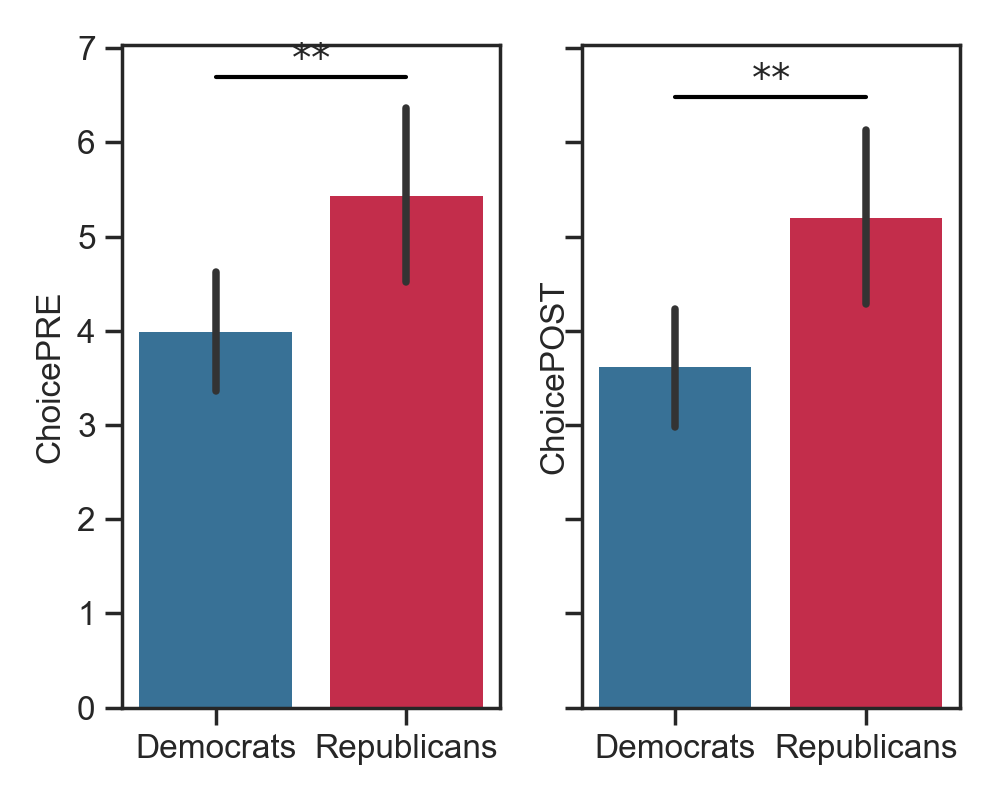

In [8]:
pal1 = ["#2874A6", "#DC143C"]

fig, ax = plt.subplots(1,2, figsize=(5,4), sharey=True)

sns.barplot(x="ide", y="ChoicePRE", data=AVDATA, \
            palette=pal1, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[0])
datahandles = np.array([L.get_xydata() for L in ax[0].get_lines()])
_, p = stats.ttest_ind(AVDATA.loc[AVDATA["ide"]==1, "ChoicePRE"], \
                       AVDATA.loc[AVDATA["ide"]==2, "ChoicePRE"])
bff.barplot_annotate_brackets(ax[0], 0, 1, p, datahandles, dh=0.05, fs=14)
ax[0].set_xticklabels(['Democrats', "Republicans"])


sns.barplot(x="ide", y="ChoicePOST", data=AVDATA, \
            palette=pal1, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[1])
datahandles = np.array([L.get_xydata() for L in ax[1].get_lines()])
_, p = stats.ttest_ind(AVDATA.loc[AVDATA["ide"]==1, "ChoicePOST"], \
                       AVDATA.loc[AVDATA["ide"]==2, "ChoicePOST"])
bff.barplot_annotate_brackets(ax[1], 0, 1, p, datahandles, dh=0.05, fs=14)
ax[1].set_xticklabels(['Democrats', "Republicans"])

ax[0].set_xlabel("");
ax[1].set_xlabel("");


plt.tight_layout()


In [10]:
%load_ext rpy2.ipython
# %R library(lme4)
%R library(lmerTest)

import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/envs/research/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
R[write to console]: Loading required package: lme4

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step




In [11]:
%Rpush DATA

In [12]:
%%R

M <- lmer(ChoicePRE ~  BeliefPRE + (1 | partnum) + (1 | itemnum), data = DATA)
print(summary(M))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: ChoicePRE ~ BeliefPRE + (1 | partnum) + (1 | itemnum)
   Data: DATA

REML criterion at convergence: 24288.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.1787 -0.3867 -0.1595  0.0534  8.7176 

Random effects:
 Groups   Name        Variance Std.Dev.
 partnum  (Intercept)   8.743   2.957  
 itemnum  (Intercept)   3.650   1.910  
 Residual             124.460  11.156  
Number of obs: 3144, groups:  partnum, 393; itemnum, 8

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept) 1.431e+00  8.161e-01 1.243e+01   1.754    0.104    
BeliefPRE   5.817e-02  7.313e-03 2.440e+03   7.953 2.75e-15 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
BeliefPRE -0.471


In [14]:
%%R

M <- lmer(deltaC ~  deltaB + ChoicePRE + (1 | partnum) + (1 | itemnum), data = DATA)
print(summary(M))

R[write to console]: boundary (singular) fit: see ?isSingular



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: deltaC ~ deltaB + ChoicePRE + (1 | partnum) + (1 | itemnum)
   Data: DATA

REML criterion at convergence: 22546.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.5766 -0.1853 -0.1425 -0.0682 11.3919 

Random effects:
 Groups   Name        Variance  Std.Dev. 
 partnum  (Intercept) 1.321e-07 0.0003635
 itemnum  (Intercept) 1.322e-02 0.1149833
 Residual             7.583e+01 8.7081269
Number of obs: 3144, groups:  partnum, 393; itemnum, 8

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)  1.298e+00  1.710e-01  8.806e+00   7.590 3.79e-05 ***
deltaB       8.539e-03  3.405e-03  6.275e+01   2.507   0.0148 *  
ChoicePRE   -3.617e-01  1.313e-02  2.515e+03 -27.546  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr) deltaB
deltaB    -0.034       
ChoicePRE -0.345  0.083

In [15]:
# Load file (from same directory as the notebook)
df2 = pd.read_excel(os.path.expanduser("Book2Prep.xlsx"))
df2.head()

,Bchange,Cchange,IncDec,BeliefPOST,ChoicePOST,BeliefPRE,ChoicePRE
0,27.00,7.5,1,74.75,20.0,47.75,12.5
1,1.75,2.5,1,84.75,12.5,83.00,10.0
2,-2.50,0.0,1,58.75,10.0,61.25,10.0
3,2.50,0.0,1,91.00,10.0,88.50,10.0
4,40.50,-25.0,1,64.75,0.0,24.25,25.0


In [16]:
tmp = pd.melt(df2, id_vars=['IncDec'], value_vars=['BeliefPRE', 'BeliefPOST'],
                   var_name='PrePost', value_name='Belief')

tmp.loc[tmp["IncDec"]==1, :].head()

,IncDec,PrePost,Belief
0,1,BeliefPRE,47.75
1,1,BeliefPRE,83.00
2,1,BeliefPRE,61.25
3,1,BeliefPRE,88.50
4,1,BeliefPRE,24.25


<IPython.core.display.Javascript object>


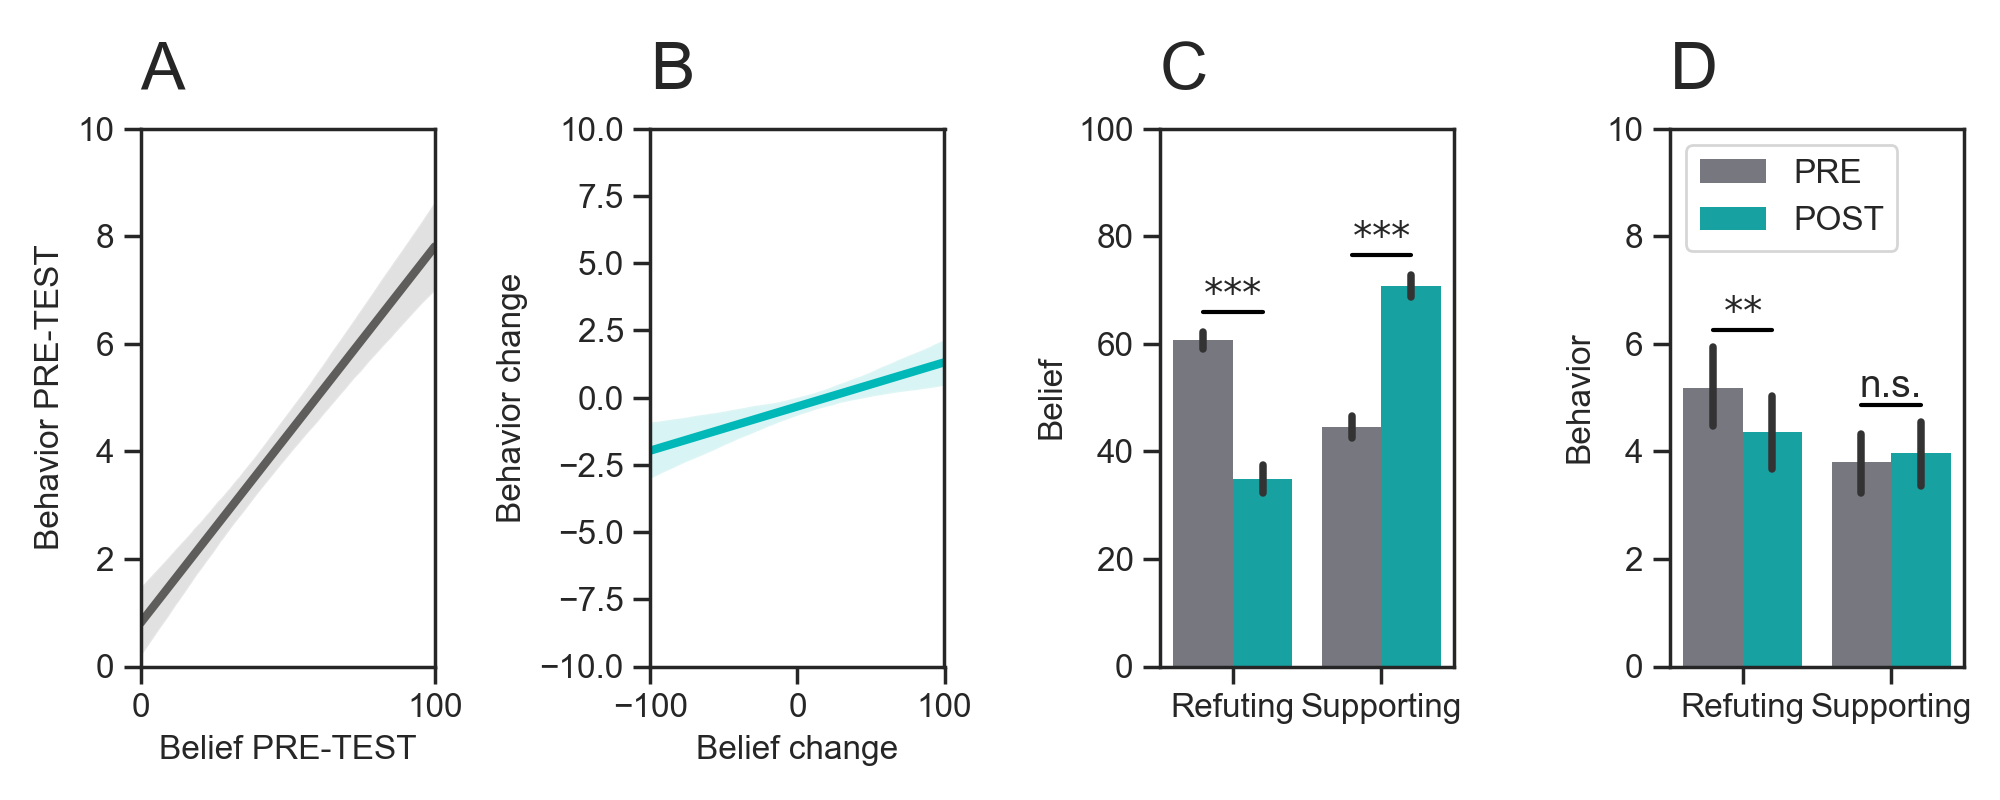

In [18]:
fig, ax = plt.subplots(1,4, figsize=(10,4))

sns.regplot(x=DATA.BeliefPRE, y=DATA.ChoicePRE, scatter_kws={"s": 0}, \
            line_kws={"color":"#3D3C3A","alpha":.8,"lw":3}, ax=ax[0])
ax[0].set_ylim(0,10)
ax[0].set_ylabel("Behavior PRE-TEST")
ax[0].set_xlabel("Belief PRE-TEST")
bff.panellabel(ax[0], "A")


sns.regplot(x=DATA.deltaB, y=DATA.deltaC, scatter_kws={"s": 0}, \
            line_kws={"color":"#00B8B8","alpha":1,"lw":3}, ax=ax[1])
ax[1].set_ylim(-10,10)
ax[1].set_ylabel("Behavior change")
ax[1].set_xlabel("Belief change")
bff.panellabel(ax[1], "B")

pal1 = ["#747681", "#00B8B8"]

tmp = pd.melt(df2, id_vars=['IncDec'], value_vars=['BeliefPRE', 'BeliefPOST'],
                   var_name='PrePost', value_name='Belief')


sns.barplot(x="IncDec", y="Belief", hue="PrePost", data=tmp, \
            palette=pal1, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[2])
datahandles = np.array([L.get_xydata() for L in ax[2].get_lines()])
_, p = stats.ttest_rel(tmp.loc[np.logical_and(tmp["IncDec"]==0, tmp["PrePost"]=="BeliefPRE"), "Belief"], \
                       tmp.loc[np.logical_and(tmp["IncDec"]==0, tmp["PrePost"]=="BeliefPOST"), "Belief"])
bff.barplot_annotate_brackets(ax[2], 0, 2, p, datahandles, dh=0.05, fs=14)
_, p = stats.ttest_rel(tmp.loc[np.logical_and(tmp["IncDec"]==1, tmp["PrePost"]=="BeliefPRE"), "Belief"], \
                       tmp.loc[np.logical_and(tmp["IncDec"]==1, tmp["PrePost"]=="BeliefPOST"), "Belief"])
bff.barplot_annotate_brackets(ax[2], 1, 3, p, datahandles, dh=0.05, fs=14)
ax[2].set_xticklabels(['Refuting', "Supporting"])
ax[2].set_xlabel("")
ax[2].set_ylim([0,100])
ax[2].get_legend().remove()
bff.panellabel(ax[2], "C")

tmp = pd.melt(df2, id_vars=['IncDec'], value_vars=['ChoicePRE', 'ChoicePOST'],
                   var_name='PrePost', value_name='Choice')

sns.barplot(x="IncDec", y="Choice", hue="PrePost", data=tmp, \
            palette=pal1, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[3]) 
ax[3].get_legend().remove()
ax[3].legend(ax[3].patches[0:3:2], ['PRE', 'POST'], loc="upper left")
datahandles = np.array([L.get_xydata() for L in ax[3].get_lines()])
_, p = stats.ttest_rel(tmp.loc[np.logical_and(tmp["IncDec"]==0, tmp["PrePost"]=="ChoicePRE"), "Choice"], \
                       tmp.loc[np.logical_and(tmp["IncDec"]==0, tmp["PrePost"]=="ChoicePOST"), "Choice"])
bff.barplot_annotate_brackets(ax[3], 0, 2, p, datahandles, dh=0.05, fs=14)

_, p = stats.ttest_rel(tmp.loc[np.logical_and(tmp["IncDec"]==1, tmp["PrePost"]=="ChoicePRE"), "Choice"], \
                       tmp.loc[np.logical_and(tmp["IncDec"]==1, tmp["PrePost"]=="ChoicePOST"), "Choice"])
bff.barplot_annotate_brackets(ax[3], 1, 3, p, datahandles, dh=0.05, fs=14)
ax[3].set_xticklabels(['Refuting', "Supporting"])
ax[3].set_xlabel("")
ax[3].set_ylabel("Behavior")
ax[3].set_ylim([0,10])
bff.panellabel(ax[3], "D")
plt.tight_layout()
plt.savefig('figNSF.jpg', dpi=200, format="jpg")

In [19]:
# Load file (from same directory as the notebook)
df = pd.read_excel(os.path.expanduser("demrepREP.xlsx"), index_col=0)
df.head()

,Unnamed: 1,BeliefPRE1,BeliefPRE2,BeliefPRE3,BeliefPRE4,BeliefPRE5,BeliefPRE6,BeliefPRE7,BeliefPRE8,BehavPRE1,...,Cchange2,Cchange3,Cchange4,Cchange5,Cchange6,Cchange7,Cchange8,BeliefPREd,ChoicePREi,ChoicePREd
Response ID,,,,,,,,,,,,,,,,,,,,,
R_1re3AQ8CMYkF47P,NaN,40,91,86,100,9,51,4,82,10,...,40,-10,-20,0,0,0,0,68.00,12.5,12.5
R_3suF0nAzuReK8pA,NaN,71,86,82,75,92,83,97,41,10,...,10,-10,0,0,0,0,0,73.75,10.0,12.5
R_1rD5IT1FeMs4jjR,NaN,59,60,55,59,65,61,63,60,10,...,0,0,-10,0,0,0,10,59.25,10.0,12.5
R_2sd1nTCMARJS5Sw,NaN,91,84,85,91,90,89,88,90,10,...,0,-10,0,0,0,0,0,88.50,10.0,12.5
R_phDbhhnD3WJUr3X,NaN,4,40,79,100,28,25,0,99,100,...,0,0,50,0,0,0,0,69.50,25.0,0.0


In [20]:
# Extract columns with df.target or df["target"] or df.loc[:,"target"]
age = df.loc[:, "Age"]
ide = df.loc[:,"Ide"]

BeliefPOSTdem = df.loc[:,"BeliefPOSTdem"]
BeliefPOSTrep = df.loc[:,"BeliefPOSTrep"]
ChoicePOSTdem = df.loc[:,"ChoicePOSTdem"]
ChoicePOSTrep = df.loc[:,"ChoicePOSTrep"]
RBchangedem = df.loc[:,"Rbchangedem"]
RBchangerep = df.loc[:,"Rbchangerep"]
RCchangedem = df.loc[:,"Rcchangedem"]
RCchangerep = df.loc[:,"Rcchangerep"]

partnum = np.arange(ide.size)

In [21]:
# Extract data with df.loc[:,"datastart":"dataend"]
BeliefPREd = df.loc[:, "BeliefPRE1":"BeliefPRE4"]
BeliefPREr = df.loc[:, "BeliefPRE5":"BeliefPRE8"]

BeliefPOSTd = df.loc[:, "BeliefPOST1":"BeliefPOST4"]
BeliefPOSTr = df.loc[:, "BeliefPOST5":"BeliefPOST8"]

ChoicePREd = df.loc[:, "BehavPRE1":"BehavPRE4"]
ChoicePREr = df.loc[:, "BehavPRE5":"BehavPRE8"]

ChoicePOSTd = df.loc[:, "BehavPOST1":"BehavPOST4"]
ChoicePOSTr = df.loc[:, "BehavPOST5":"BehavPOST8"]

RdeltaBd = df.loc[:, "RB1":"RB4"]
RdeltaBr = df.loc[:, "RB5":"RB8"]

RdeltaCd = df.loc[:, "RC1":"RC4"]
RdeltaCr = df.loc[:, "RC5":"RC8"]

deltaBd = df.loc[:, "Bchange1":"Bchange4"]
deltaBr = df.loc[:, "Bchange5":"Bchange8"]

deltaCd = df.loc[:, "Cchange1":"Cchange4"]
deltaCr = df.loc[:, "Cchange5":"Cchange8"]

sz = RdeltaBd.shape
itemnum = np.arange(sz[-1])
print(sz)

(393, 4)


In [22]:
# Data and row-wise labels first
names = ["BeliefPREd","BeliefPREr", "BeliefPOSTd","BeliefPOSTr", "ChoicePREd","ChoicePREr", "ChoicePOSTd","ChoicePOSTr", \
         'RdeltaBd', 'RdeltaBr','RdeltaCd','RdeltaCr', 'deltaBd','deltaBr','deltaCd','deltaCr','itemnum', \
         "age", "ide", 'BeliefPOSTdem', 'BeliefPOSTrep','ChoicePOSTdem','ChoicePOSTrep','RBchangedem','RBchangerep','RCchangedem','RCchangerep',"partnum"]
data_packed = np.broadcast_arrays(BeliefPREd,BeliefPREr, BeliefPOSTd,BeliefPOSTr, ChoicePREd,ChoicePREr, ChoicePOSTd,ChoicePOSTr, RdeltaBd,RdeltaBr, RdeltaCd,RdeltaCr, deltaBd,deltaBr, deltaCd,deltaCr, itemnum)
# Then column-wise labels
cols = [np.tile(a, (sz[1],1)).T for a in [age, ide, BeliefPOSTdem, BeliefPOSTrep,ChoicePOSTdem,ChoicePOSTrep,RBchangedem,RBchangerep,RCchangedem,RCchangerep, partnum]]
data_packed += cols

data_unpacked = np.vstack([np.reshape(a, (1,-1), order="C") for a in data_packed]).T
politicalDATA = pd.DataFrame(data=data_unpacked, columns=names)

politicalDATA.head()

,BeliefPREd,BeliefPREr,BeliefPOSTd,BeliefPOSTr,ChoicePREd,ChoicePREr,ChoicePOSTd,ChoicePOSTr,RdeltaBd,RdeltaBr,...,ide,BeliefPOSTdem,BeliefPOSTrep,ChoicePOSTdem,ChoicePOSTrep,RBchangedem,RBchangerep,RCchangedem,RCchangerep,partnum
0,40.0,9.0,100.0,90.0,10.0,0.0,0.0,0.0,60.0,81.0,...,1.0,55.5,29.25,25.0,0.0,63.50,4.0,17.5,0.0,0.0
1,91.0,51.0,100.0,9.0,40.0,0.0,80.0,0.0,9.0,-42.0,...,1.0,55.5,29.25,25.0,0.0,63.50,4.0,17.5,0.0,0.0
2,86.0,4.0,2.0,1.0,30.0,0.0,20.0,0.0,84.0,3.0,...,1.0,55.5,29.25,25.0,0.0,63.50,4.0,17.5,0.0,0.0
3,100.0,82.0,20.0,17.0,20.0,0.0,0.0,0.0,80.0,65.0,...,1.0,55.5,29.25,25.0,0.0,63.50,4.0,17.5,0.0,0.0
4,71.0,92.0,80.0,82.0,10.0,10.0,10.0,10.0,9.0,-10.0,...,1.0,84.5,84.75,10.0,12.5,-6.25,-5.0,5.0,0.0,1.0


In [23]:
# Group and average data within participant
politicalAVDATA = politicalDATA.groupby(["partnum"], as_index=False).mean()
politicalAVDATA.head()

,partnum,BeliefPREd,BeliefPREr,BeliefPOSTd,BeliefPOSTr,ChoicePREd,ChoicePREr,ChoicePOSTd,ChoicePOSTr,RdeltaBd,...,age,ide,BeliefPOSTdem,BeliefPOSTrep,ChoicePOSTdem,ChoicePOSTrep,RBchangedem,RBchangerep,RCchangedem,RCchangerep
0,0.0,79.25,36.50,55.50,29.25,25.0,0.0,25.0,0.0,58.25,...,43.0,1.0,55.50,29.25,25.0,0.0,63.50,4.00,17.5,0.000000
1,1.0,78.50,78.25,84.50,84.75,10.0,12.5,10.0,12.5,-1.50,...,54.0,1.0,84.50,84.75,10.0,12.5,-6.25,-5.00,5.0,0.000000
2,2.0,58.25,62.25,56.75,58.25,12.5,10.0,10.0,12.5,0.50,...,46.0,1.0,56.75,58.25,10.0,12.5,-0.75,1.75,2.5,-3.333333
3,3.0,87.75,89.25,89.25,90.50,12.5,10.0,10.0,10.0,0.50,...,35.0,1.0,89.25,90.50,10.0,10.0,1.50,1.00,2.5,0.000000
4,4.0,55.75,38.00,74.00,42.25,25.0,0.0,12.5,0.0,57.75,...,32.0,1.0,74.00,42.25,12.5,0.0,41.00,-31.50,-12.5,0.000000


In [24]:
# Load file (from same directory as the notebook)
df3 = pd.read_excel(os.path.expanduser("Book3rep.xlsx"))
df3.head()

,DemRep,RBchange,RCchange,BeliefPOST,ChoicePOST,BeliefPRE,ChoicePRE,Ide
0,1,58.25,15.0,55.50,25.0,79.25,25.0,1
1,1,-1.50,5.0,84.50,10.0,78.50,10.0,1
2,1,0.50,2.5,56.75,10.0,58.25,12.5,1
3,1,0.50,2.5,89.25,10.0,87.75,12.5,1
4,1,57.75,-37.5,74.00,12.5,55.75,25.0,1


<IPython.core.display.Javascript object>


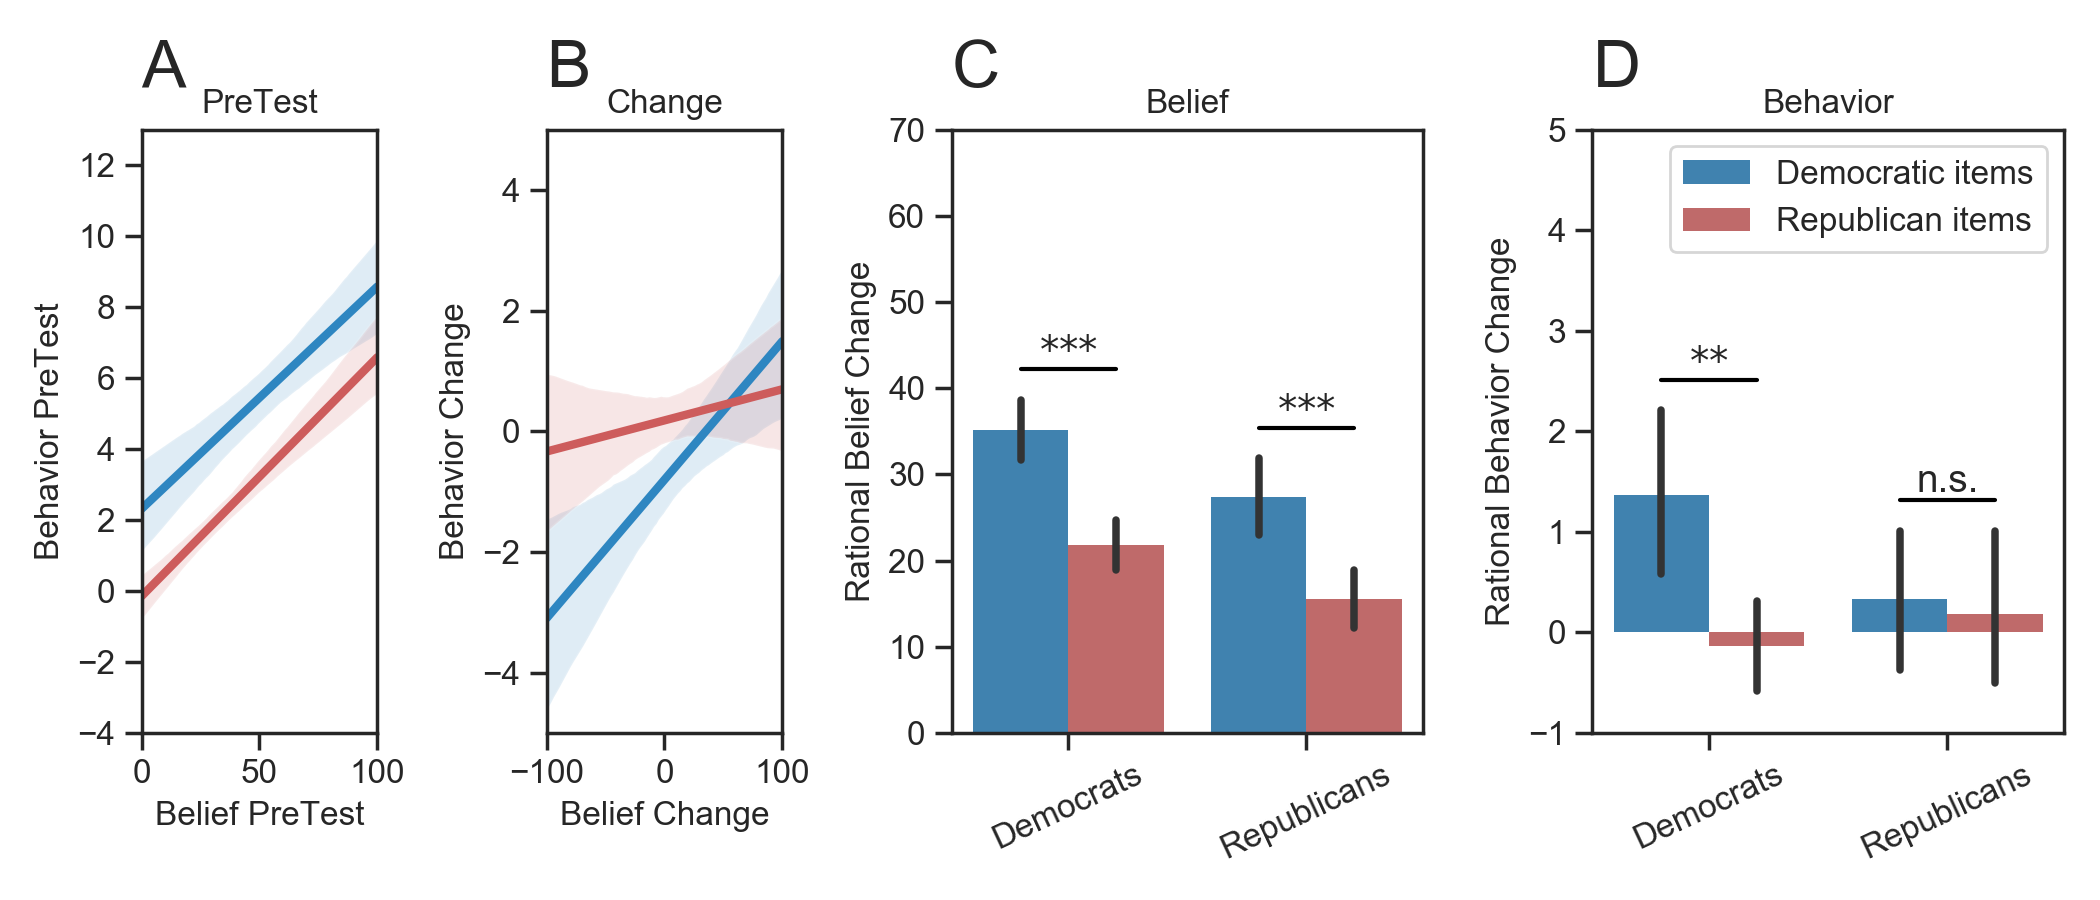

In [27]:
fig, ax = plt.subplots(1,4, figsize=(10.5,4.5), gridspec_kw={"width_ratios": [1, 1, 2, 2]})

sns.regplot(x=politicalDATA.BeliefPREd, y=politicalDATA.ChoicePREd, scatter_kws={"s": 0}, \
            line_kws={"color":"#2E86C1","alpha":1,"lw":3}, ax=ax[0])
sns.regplot(x=politicalDATA.BeliefPREr, y=politicalDATA.ChoicePREr, scatter_kws={"s": 0}, \
            line_kws={"color":"#CD5C5C","alpha":1,"lw":3}, ax=ax[0])
ax[0].set_title('PreTest')
ax[0].set_xlabel("Belief PreTest")
ax[0].set_ylabel("Behavior PreTest")
ax[0].set_ylim(-4,13)
bff.panellabel(ax[0], "A")


sns.regplot(x=politicalDATA.deltaBd, y=politicalDATA.deltaCd, scatter_kws={"s": 0}, \
            line_kws={"color":"#2E86C1","alpha":1,"lw":3}, ax=ax[1])
sns.regplot(x=politicalDATA.deltaBr, y=politicalDATA.deltaCr, scatter_kws={"s": 0}, \
            line_kws={"color":"#CD5C5C","alpha":1,"lw":3}, ax=ax[1])
ax[1].set_title('Change')
ax[1].set_xlabel("Belief Change")
ax[1].set_ylabel("Behavior Change")
ax[1].set_ylim(-5,5)
bff.panellabel(ax[1], "B")

plt.legend(labels=['Democratic items', 'Republican items'])

plt.tight_layout()

pal1l = ["#2E86C1", "#CD5C5C"]
sns.barplot(x="Ide", y="RBchange", hue="DemRep", data=df3, \
            palette=pal1l, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[2])
ax[2].set_xticklabels(['Democrats', "Republicans", "Independents"], rotation=25)
ax[2].set_xlabel("")
ax[2].set_ylabel("Rational Belief Change")
ax[2].set_ylim([0,70])
ax[2].set_title('Belief')
ax[2].get_legend().remove()
bff.panellabel(ax[2], "C")
datahandles = np.array([L.get_xydata() for L in ax[2].get_lines()])
_, p = stats.ttest_rel(df3.loc[np.logical_and(df3["DemRep"]==1, df3["Ide"]==1), "RBchange"], \
                       df3.loc[np.logical_and(df3["DemRep"]==2, df3["Ide"]==1), "RBchange"])
bff.barplot_annotate_brackets(ax[2], 0, 2, p, datahandles, dh=0.05, fs=14)
_, p = stats.ttest_rel(df3.loc[np.logical_and(df3["DemRep"]==1, df3["Ide"]==2), "RBchange"], \
                       df3.loc[np.logical_and(df3["DemRep"]==2, df3["Ide"]==2), "RBchange"])
bff.barplot_annotate_brackets(ax[2], 1, 3, p, datahandles, dh=0.05, fs=14)




sns.barplot(x="Ide", y="RCchange", hue="DemRep", data=df3, \
            palette=pal1l, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[3])
ax[3].set_xticklabels(['Democrats', "Republicans", "Independents"], rotation=25)
ax[3].set_xlabel("")
ax[3].set_ylabel("Rational Behavior Change")
ax[3].legend(ax[3].patches[::3], ['Democratic items', 'Republican items'], loc="upper right")
ax[3].set_ylim([-1,5])
ax[3].set_title('Behavior')
bff.panellabel(ax[3], "D")
datahandles = np.array([L.get_xydata() for L in ax[3].get_lines()])
_, p = stats.ttest_rel(df3.loc[np.logical_and(df3["DemRep"]==1, df3["Ide"]==1), "RCchange"], \
                       df3.loc[np.logical_and(df3["DemRep"]==2, df3["Ide"]==1), "RCchange"])
bff.barplot_annotate_brackets(ax[3], 0, 2, p, datahandles, dh=0.05, fs=14)
_, p = stats.ttest_rel(df3.loc[np.logical_and(df3["DemRep"]==1, df3["Ide"]==2), "RCchange"], \
                       df3.loc[np.logical_and(df3["DemRep"]==2, df3["Ide"]==2), "RCchange"])
bff.barplot_annotate_brackets(ax[3], 1, 3, p, datahandles, dh=0.05, fs=14)


plt.tight_layout()
plt.savefig('fig3.jpg', dpi=400, format="jpg")

<IPython.core.display.Javascript object>


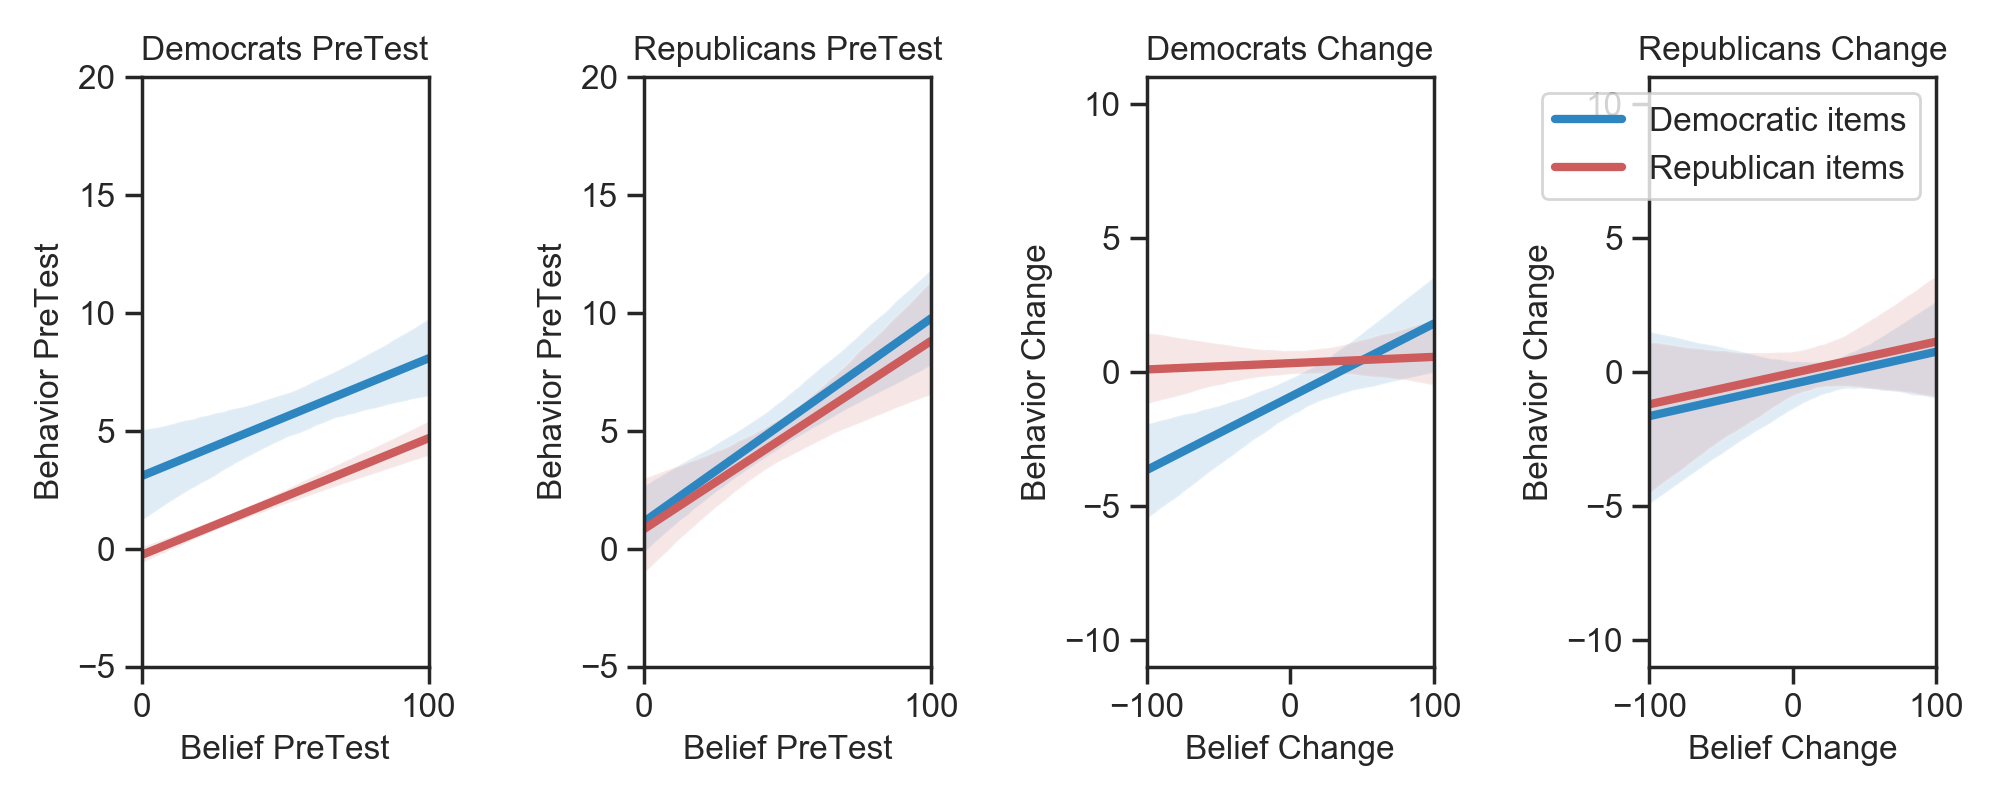

In [28]:
fig, ax = plt.subplots(1,4, figsize=(10,4))

sns.regplot(x=politicalDATA.loc[politicalDATA["ide"]==1, "BeliefPREd"], \
            y=politicalDATA.loc[politicalDATA["ide"]==1, "ChoicePREd"], \
            scatter_kws={"s": 0}, \
            line_kws={"color":"#2E86C1","alpha":1,"lw":3}, ax=ax[0])
sns.regplot(x=politicalDATA.loc[politicalDATA["ide"]==1, "BeliefPREr"], \
            y=politicalDATA.loc[politicalDATA["ide"]==1, "ChoicePREr"], \
            scatter_kws={"s": 0}, \
            line_kws={"color":"#CD5C5C","alpha":1,"lw":3}, ax=ax[0])
ax[0].set_title('Democrats PreTest')
ax[0].set_xlabel("Belief PreTest")
ax[0].set_ylabel("Behavior PreTest")
ax[0].set_ylim(-5,20)


sns.regplot(x=politicalDATA.loc[politicalDATA["ide"]==2, "BeliefPREd"], \
            y=politicalDATA.loc[politicalDATA["ide"]==2, "ChoicePREd"], \
            scatter_kws={"s": 0}, \
            line_kws={"color":"#2E86C1","alpha":1,"lw":3}, ax=ax[1])
sns.regplot(x=politicalDATA.loc[politicalDATA["ide"]==2, "BeliefPREr"], \
            y=politicalDATA.loc[politicalDATA["ide"]==2, "ChoicePREr"], \
            scatter_kws={"s": 0}, \
            line_kws={"color":"#CD5C5C","alpha":1,"lw":3}, ax=ax[1])
ax[1].set_title('Republicans PreTest')
ax[1].set_xlabel("Belief PreTest")
ax[1].set_ylabel("Behavior PreTest")
ax[1].set_ylim(-5,20)



sns.regplot(x=politicalDATA.loc[politicalDATA["ide"]==1, "deltaBd"], \
            y=politicalDATA.loc[politicalDATA["ide"]==1, "deltaCd"], scatter_kws={"s": 0}, \
            line_kws={"color":"#2E86C1","alpha":1,"lw":3}, ax=ax[2])
sns.regplot(x=politicalDATA.loc[politicalDATA["ide"]==1, "deltaBr"], \
            y=politicalDATA.loc[politicalDATA["ide"]==1, "deltaCr"], scatter_kws={"s": 0}, \
            line_kws={"color":"#CD5C5C","alpha":1,"lw":3}, ax=ax[2])
ax[2].set_title('Democrats Change')
ax[2].set_xlabel("Belief Change")
ax[2].set_ylabel("Behavior Change")
ax[2].set_ylim(-11,11)


sns.regplot(x=politicalDATA.loc[politicalDATA["ide"]==2, "deltaBd"], \
            y=politicalDATA.loc[politicalDATA["ide"]==2, "deltaCd"], scatter_kws={"s": 0}, \
            line_kws={"color":"#2E86C1","alpha":1,"lw":3}, ax=ax[3])
sns.regplot(x=politicalDATA.loc[politicalDATA["ide"]==2, "deltaBr"], \
            y=politicalDATA.loc[politicalDATA["ide"]==2, "deltaCr"], scatter_kws={"s": 0}, \
            line_kws={"color":"#CD5C5C","alpha":1,"lw":3}, ax=ax[3])
ax[3].set_title('Republicans Change')
ax[3].set_xlabel("Belief Change")
ax[3].set_ylabel("Behavior Change")
ax[3].set_ylim(-11,11)


plt.legend(labels=['Democratic items', 'Republican items'])
plt.tight_layout()
plt.savefig('fig.jpg', dpi=400, format="jpg")

In [29]:
# Load file (from same directory as the notebook)
df4 = pd.read_excel(os.path.expanduser("Book4repB.xlsx"))
df4.head()

,Bpre,Cpre,Bchange,Cchange,DemRep,partnum,ide
0,40,10,60,-10,1,1,1
1,71,10,9,0,1,2,1
2,59,10,-2,0,1,3,1
3,91,10,-1,0,1,4,1
4,4,100,96,-100,1,5,1


<IPython.core.display.Javascript object>


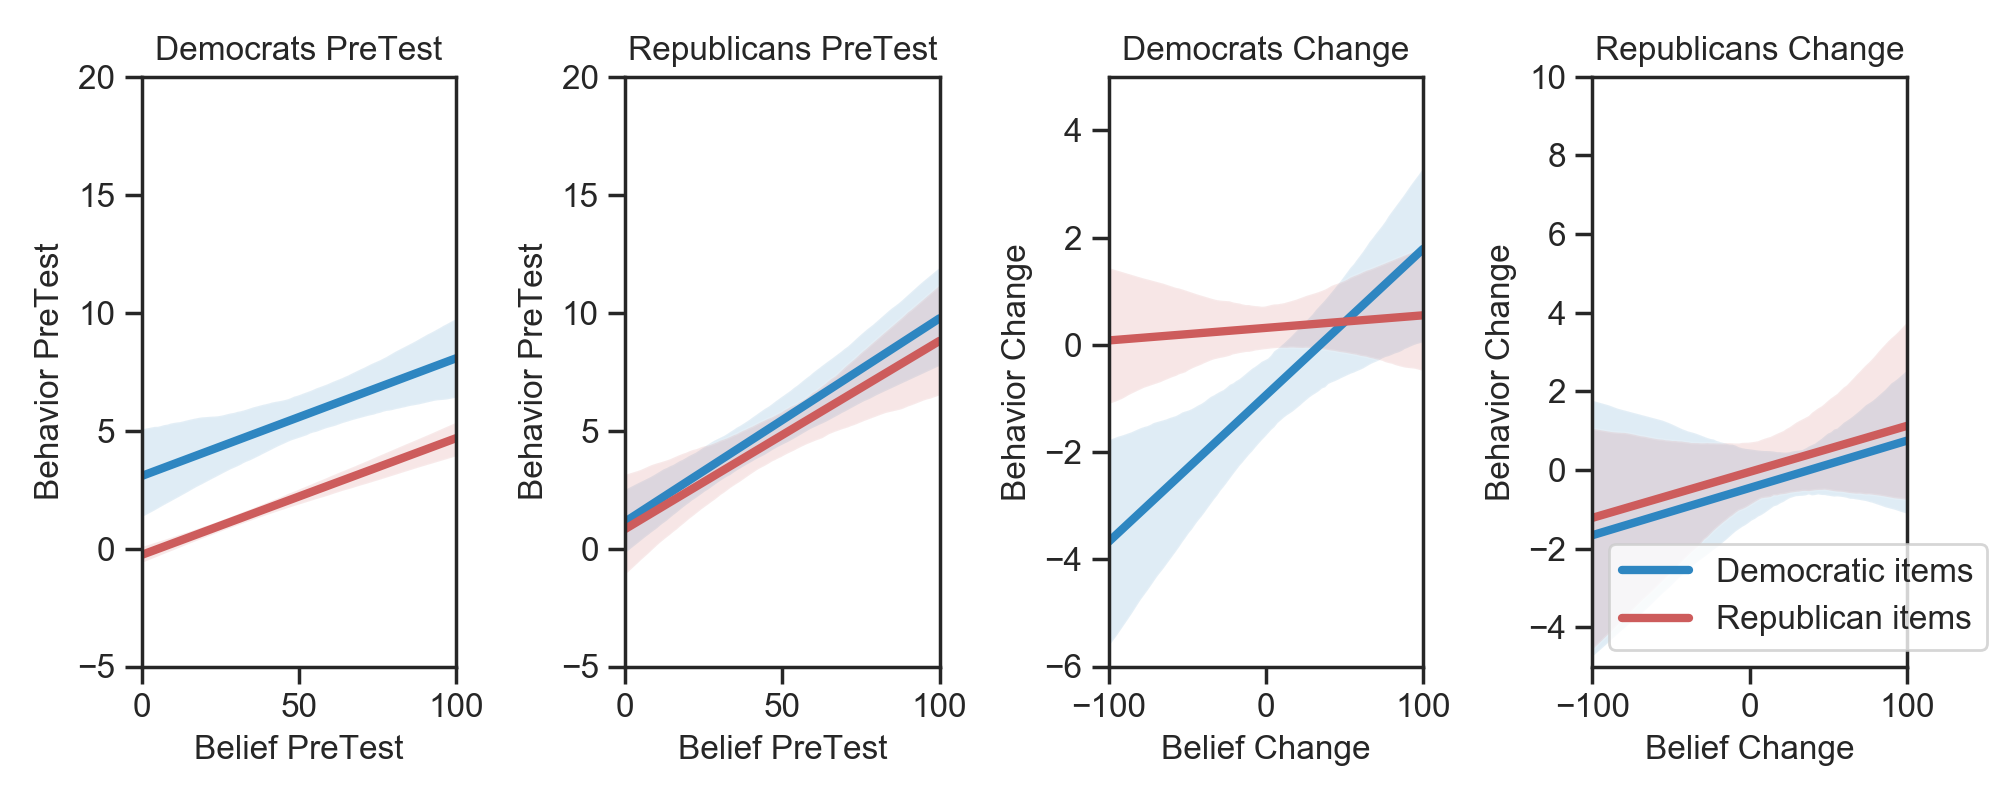

In [30]:
fig, ax = plt.subplots(1,4, figsize=(10,4))

sns.regplot(x=df4.loc[np.logical_and(df4["ide"]==1, df4["DemRep"]==1), "Bpre"], \
            y=df4.loc[np.logical_and(df4["ide"]==1, df4["DemRep"]==1), "Cpre"], \
            scatter_kws={"s": 0}, \
            line_kws={"color":"#2E86C1","alpha":1,"lw":3}, ax=ax[0])
sns.regplot(x=df4.loc[np.logical_and(df4["ide"]==1, df4["DemRep"]==2), "Bpre"], \
            y=df4.loc[np.logical_and(df4["ide"]==1, df4["DemRep"]==2), "Cpre"], \
            scatter_kws={"s": 0}, \
            line_kws={"color":"#CD5C5C","alpha":1,"lw":3}, ax=ax[0])
ax[0].set_title('Democrats PreTest')
ax[0].set_xlabel("Belief PreTest")
ax[0].set_ylabel("Behavior PreTest")
ax[0].set_ylim(-5,20)


sns.regplot(x=df4.loc[np.logical_and(df4["ide"]==2, df4["DemRep"]==1), "Bpre"], \
            y=df4.loc[np.logical_and(df4["ide"]==2, df4["DemRep"]==1), "Cpre"], \
            scatter_kws={"s": 0}, \
            line_kws={"color":"#2E86C1","alpha":1,"lw":3}, ax=ax[1])
sns.regplot(x=df4.loc[np.logical_and(df4["ide"]==2, df4["DemRep"]==2), "Bpre"], \
            y=df4.loc[np.logical_and(df4["ide"]==2, df4["DemRep"]==2), "Cpre"], \
            scatter_kws={"s": 0}, \
            line_kws={"color":"#CD5C5C","alpha":1,"lw":3}, ax=ax[1])
ax[1].set_title('Republicans PreTest')
ax[1].set_xlabel("Belief PreTest")
ax[1].set_ylabel("Behavior PreTest")
ax[1].set_ylim(-5,20)



sns.regplot(x=df4.loc[np.logical_and(df4["ide"]==1, df4["DemRep"]==1), "Bchange"], \
            y=df4.loc[np.logical_and(df4["ide"]==1, df4["DemRep"]==1), "Cchange"], \
            scatter_kws={"s": 0}, \
            line_kws={"color":"#2E86C1","alpha":1,"lw":3}, ax=ax[2])
sns.regplot(x=df4.loc[np.logical_and(df4["ide"]==1, df4["DemRep"]==2), "Bchange"], \
            y=df4.loc[np.logical_and(df4["ide"]==1, df4["DemRep"]==2), "Cchange"], \
            scatter_kws={"s": 0}, \
            line_kws={"color":"#CD5C5C","alpha":1,"lw":3}, ax=ax[2])
ax[2].set_title('Democrats Change')
ax[2].set_xlabel("Belief Change")
ax[2].set_ylabel("Behavior Change")
ax[2].set_ylim(-6,5)


sns.regplot(x=df4.loc[np.logical_and(df4["ide"]==2, df4["DemRep"]==1), "Bchange"], \
            y=df4.loc[np.logical_and(df4["ide"]==2, df4["DemRep"]==1), "Cchange"], \
            scatter_kws={"s": 0}, \
            line_kws={"color":"#2E86C1","alpha":1,"lw":3}, ax=ax[3])
sns.regplot(x=df4.loc[np.logical_and(df4["ide"]==2, df4["DemRep"]==2), "Bchange"], \
            y=df4.loc[np.logical_and(df4["ide"]==2, df4["DemRep"]==2), "Cchange"], \
            scatter_kws={"s": 0}, \
            line_kws={"color":"#CD5C5C","alpha":1,"lw":3}, ax=ax[3])
ax[3].set_title('Republicans Change')
ax[3].set_xlabel("Belief Change")
ax[3].set_ylabel("Behavior Change")
ax[3].set_ylim(-5,10)


plt.legend(labels=['Democratic items', 'Republican items'])
plt.tight_layout()

In [31]:
%Rpush df4

In [32]:
%%R

M <- lmer(Cchange ~  Bchange:as.factor(DemRep):as.factor(ide) + (1 | partnum), data = df4)
print(summary(M))

R[write to console]: boundary (singular) fit: see ?isSingular



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: Cchange ~ Bchange:as.factor(DemRep):as.factor(ide) + (1 | partnum)
   Data: df4

REML criterion at convergence: 23234.9

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-10.5650  -0.0058   0.0300   0.0565  10.3953 

Random effects:
 Groups   Name        Variance Std.Dev.
 partnum  (Intercept)  0.00    0.000   
 Residual             94.01    9.696   
Number of obs: 3144, groups:  partnum, 393

Fixed effects:
                                             Estimate Std. Error         df
(Intercept)                                -2.908e-01  1.735e-01  3.139e+03
Bchange:as.factor(DemRep)1:as.factor(ide)1  2.843e-02  5.761e-03  3.139e+03
Bchange:as.factor(DemRep)2:as.factor(ide)1  3.516e-03  7.043e-03  3.139e+03
Bchange:as.factor(DemRep)1:as.factor(ide)2  1.170e-02  8.629e-03  3.139e+03
Bchange:as.factor(DemRep)2:as.factor(ide)2  1.158e-02  1.134e-02  3.139e+03
                     

In [33]:
%%R

M <- lmer(Cchange ~ Bchange*as.factor(DemRep)*as.factor(ide) + (1 | partnum), data = df4)
print(summary(M))

R[write to console]: boundary (singular) fit: see ?isSingular



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: Cchange ~ Bchange * as.factor(DemRep) * as.factor(ide) + (1 |  
    partnum)
   Data: df4

REML criterion at convergence: 23225.1

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-10.4970  -0.0404  -0.0129   0.0914  10.4241 

Random effects:
 Groups   Name        Variance Std.Dev.
 partnum  (Intercept)  0.00    0.000   
 Residual             93.83    9.687   
Number of obs: 3144, groups:  partnum, 393

Fixed effects:
                                             Estimate Std. Error         df
(Intercept)                                -9.403e-01  3.040e-01  3.136e+03
Bchange                                     2.731e-02  5.771e-03  3.136e+03
as.factor(DemRep)2                          1.257e+00  4.297e-01  3.136e+03
as.factor(ide)2                             4.822e-01  5.149e-01  3.136e+03
Bchange:as.factor(DemRep)2                 -2.497e-02  9.113e-03  3.136e+03
Bchange:as.

In [34]:
%%R

M <- lmer(Cpre ~ Bpre:as.factor(DemRep):as.factor(ide) + (1 | partnum), data = df4)
print(summary(M))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: Cpre ~ Bpre:as.factor(DemRep):as.factor(ide) + (1 | partnum)
   Data: df4

REML criterion at convergence: 24327.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.0632 -0.4300 -0.1213  0.0043  8.5052 

Random effects:
 Groups   Name        Variance Std.Dev.
 partnum  (Intercept)   8.745   2.957  
 Residual             125.974  11.224  
Number of obs: 3144, groups:  partnum, 393

Fixed effects:
                                         Estimate Std. Error        df t value
(Intercept)                             1.491e+00  4.276e-01 1.491e+03   3.487
Bpre:as.factor(DemRep)1:as.factor(ide)1 6.929e-02  7.487e-03 3.061e+03   9.255
Bpre:as.factor(DemRep)2:as.factor(ide)1 1.786e-02  9.266e-03 2.892e+03   1.928
Bpre:as.factor(DemRep)1:as.factor(ide)2 7.917e-02  1.037e-02 2.400e+03   7.634
Bpre:as.factor(DemRep)2:as.factor(ide)2 6.861e-02  9.876e-03 2.419e+03   6.948
                   

In [35]:
%%R

M <- lmer(Cpre ~ Bpre*as.factor(DemRep)*as.factor(ide) + (1 | partnum), data = df4)
print(summary(M))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: Cpre ~ Bpre * as.factor(DemRep) * as.factor(ide) + (1 | partnum)
   Data: df4

REML criterion at convergence: 24311.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.0606 -0.4378 -0.1599  0.0651  8.5265 

Random effects:
 Groups   Name        Variance Std.Dev.
 partnum  (Intercept)   8.598   2.932  
 Residual             125.769  11.215  
Number of obs: 3144, groups:  partnum, 393

Fixed effects:
                                          Estimate Std. Error         df
(Intercept)                              3.442e+00  7.972e-01  2.891e+03
Bpre                                     4.384e-02  1.140e-02  3.103e+03
as.factor(DemRep)2                      -3.141e+00  9.811e-01  2.990e+03
as.factor(ide)2                         -1.922e+00  1.250e+00  2.651e+03
Bpre:as.factor(DemRep)2                 -7.572e-03  1.610e-02  3.083e+03
Bpre:as.factor(ide)2                     3.487e-02 